# Import relevant Python libraries

With the Python environment initialised (with the correct libraries installed), this section imports the relevant libraries and NLTK depencies into the environment.

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.feature_selection import f_classif

from sentence_transformers import SentenceTransformer
from langdetect import detect
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

from imblearn.over_sampling import SMOTE

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Ensure NLTK dependencies are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Set Pandas columns to full view
pd.options.display.max_columns = None

[nltk_data] Downloading package punkt to /Users/malik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/malik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/malik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/malik/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Read Data

In this section, I read both the Titles JSON file, as well as two key tables from the given SQLite database, all into dataframes that will later be merged into one.

In [9]:
# Read JSON file of news article samples
titles_df = pd.read_json(path_or_buf='data/titles.jsonl', lines=True)

In [10]:
# Create a SQL connection to our SQLite database
con = sqlite3.connect("data/db.sqlite3")

# Read relevant tables into a dataframe
company_df = pd.read_sql_query("SELECT * from company", con)
news_meta_df = pd.read_sql_query("SELECT * from news_meta", con)

con.close()

# Combined Tables

In this section, I joined the given Titles JSON file, with supplementary information from the SQLite database. This involved merging the dataframe on the company_id, enhancing the dataframe with additional information such as company name, description and location.

In [11]:
# Combine news_meta_df with company_df
def left_join_news_and_company(news_meta_df, company_df):
   
    # Perform the left join
    merged_df = news_meta_df.merge(
        company_df,
        how="left",
        left_on="company_id",
        right_on="id",
        suffixes=("", "_company")
    )

    # Select and rename relevant columns
    merged_df = merged_df[
        [
            "id", "url", "published_at", "company_id", "name", "description", "location", "website", "label"
        ]
    ]

    return merged_df

full_df=left_join_news_and_company(news_meta_df, company_df)

In [12]:
# How many news articles come from companies we dont have data on
news_companies=news_meta_df['company_id'].unique()
companies_we_have=company_df['id'].unique()

print(f"Number of unique companies in the news articles: {len(news_companies)}")
print(f"Number of companies we have data on: {len(companies_we_have)}")
print(f"Number of news articles from companies we don't have data on: {len(set(news_companies) - set(companies_we_have))}")

Number of unique companies in the news articles: 561
Number of companies we have data on: 561
Number of news articles from companies we don't have data on: 0


In [13]:
# Perform a left join on titles dataframe with json samples dataframe
def left_join_titles_with_full(titles_df, full_df):

    # Perform the left join
    result_df = pd.merge(titles_df, full_df, how='left', on='id')
    
    return result_df

titles_df=left_join_titles_with_full(titles_df, full_df)

# Preprocessing

I cleaned the dataset by moving the id column to the front for better readability and removing duplicate rows based on title and company_id to ensure uniqueness. Rows with empty strings in essential columns (url, location, website) were also dropped to maintain data quality. These steps improved consistency and prepared the data for modeling.

In [14]:
# Preprocessing - Move ID column to front of dataframe
def move_id_to_front(df):
    cols = list(df.columns)

    cols.insert(0, cols.pop(cols.index('id')))
    return df[cols]
   

titles_df=move_id_to_front(titles_df)

In [15]:
# Preprocessing - Remove rows with duplicate Title - company_id combinations
def drop_duplicates_keep_first(df, columns):
    return df.drop_duplicates(subset=columns, keep='first')

print(f"Length of titles_df: {len(titles_df)}")
titles_df=drop_duplicates_keep_first(titles_df, ['title', 'company_id'])
print(f"Length of titles_df after dropping duplicates: {len(titles_df)}")

Length of titles_df: 859
Length of titles_df after dropping duplicates: 857


In [16]:
# Preprocessing - Remove empty string rows
def remove_rows_with_empty_strings(df, columns):
    return df[~df[columns].apply(lambda row: (row == "").any(), axis=1)]

print(f"Length of titles_df: {len(titles_df)}")
titles_df=remove_rows_with_empty_strings(titles_df, ['url', 'location', 'website'])
print(f"Length of titles_df after removing rows with empty strings: {len(titles_df)}")

Length of titles_df: 857
Length of titles_df after removing rows with empty strings: 849


# EDA

The exploratory data analysis section aimed to understand the dataset's structure. The title field was analyzed to identify its language distribution, counts of NaN values and empty strings were calculated for all columns, and bar plots were created for selected categorical columns. The frequency of unique name and location values was analyzed for each class label (CALENDAR, PRESS RELEASE, RESULTS) to understand category-specific trends and their associations with other features.

In [17]:
# EDA - Check distribution of different languages of titles
def detect_languages(df, column_name):
    
    df['language'] = df[column_name].apply(lambda x: detect(x) if pd.notnull(x) else 'unknown')
    
    # Print counts of each detected language
    language_counts = df['language'].value_counts()
    print("Language Counts:")
    print(language_counts)
    
    return df

# Apply language detection
titles_df=detect_languages(titles_df, 'title')

Language Counts:
language
en    757
de     19
ca     17
fr     11
ro     10
it      9
no      6
pt      4
es      3
nl      3
da      2
id      2
et      1
tl      1
tr      1
so      1
sv      1
sq      1
Name: count, dtype: int64


In [18]:
# EDA - NAN counts for each column
def print_nan_counts(df):
    print(f"Length of df: {len(df)}")
    nan_counts = df.isna().sum()
    for col, count in nan_counts.items():
        print(f"NaN count - {col}: {count}")

print_nan_counts(titles_df)

Length of df: 849
NaN count - id: 0
NaN count - title: 0
NaN count - url: 0
NaN count - published_at: 0
NaN count - company_id: 0
NaN count - name: 0
NaN count - description: 0
NaN count - location: 0
NaN count - website: 0
NaN count - label: 0
NaN count - language: 0


In [19]:
# EDA - Empty strings counts for each column
def print_empty_string_counts(df):
    print(f"Length of df: {len(df)}")
    empty_string_counts = (df == "").sum()
    for col, count in empty_string_counts.items():
        print(f"Empty string count - {col}: {count}")

print_empty_string_counts(titles_df)

Length of df: 849
Empty string count - id: 0
Empty string count - title: 0
Empty string count - url: 0
Empty string count - published_at: 0
Empty string count - company_id: 0
Empty string count - name: 0
Empty string count - description: 0
Empty string count - location: 0
Empty string count - website: 0
Empty string count - label: 0
Empty string count - language: 0


In [21]:
# EDA - Unique counts within each column
def print_unique_counts(df):
    print(f"---- Total Rows: {len(df)} ------")
    for col in df.columns:
        unique_count = df[col].nunique()
        print(f"Unique {col}: {unique_count}")
        
print_unique_counts(titles_df)

---- Total Rows: 849 ------
Unique id: 849
Unique title: 849
Unique url: 849
Unique published_at: 849
Unique company_id: 556
Unique name: 556
Unique description: 534
Unique location: 46
Unique website: 556
Unique label: 3
Unique language: 18


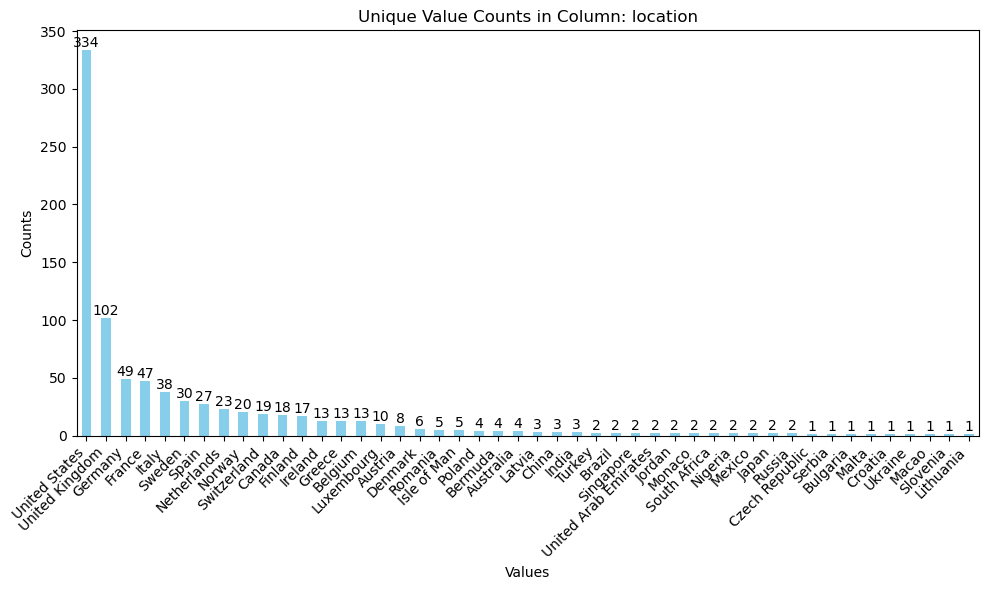

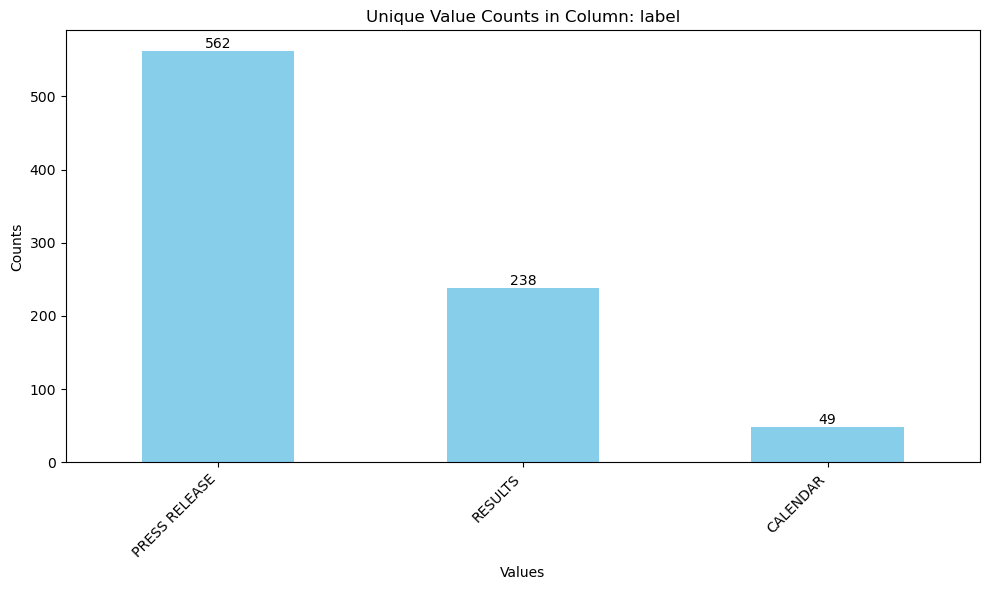

In [23]:
# EDA - Graph unique counts in various columns
def plot_unique_value_counts(df, columns):
    
    for column in columns:
        if column in df.columns:
            value_counts = df[column].value_counts()
            
            plt.figure(figsize=(10, 6))
            ax = value_counts.plot(kind='bar', color='skyblue')
            plt.title(f"Unique Value Counts in Column: {column}")
            plt.xlabel("Values")
            plt.ylabel("Counts")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            
            # Add counts to the top of each bar
            for i, count in enumerate(value_counts):
                plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)
            
            plt.show()
        else:
            print(f"Column '{column}' not found in the dataframe.")

counts_cols=['location', 'label']
plot_unique_value_counts(titles_df, counts_cols)

In [25]:
# EDA - Find duplicate rows given a column
def get_duplicates(df, columns):
    return df[df.duplicated(subset=columns, keep=False)]

get_duplicates(titles_df, ['title'])

,id,title,url,published_at,company_id,name,description,location,website,label,language


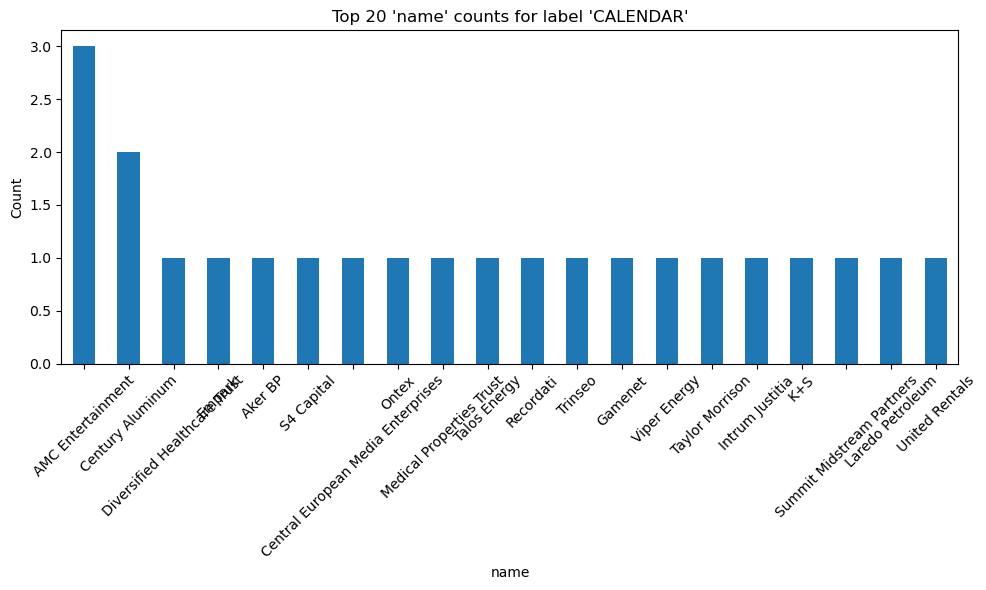

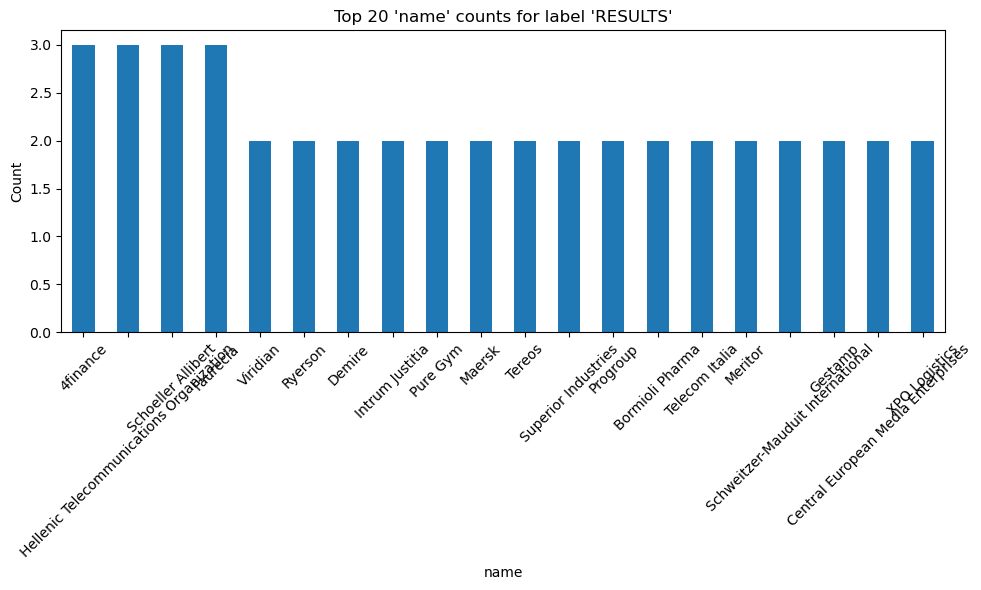

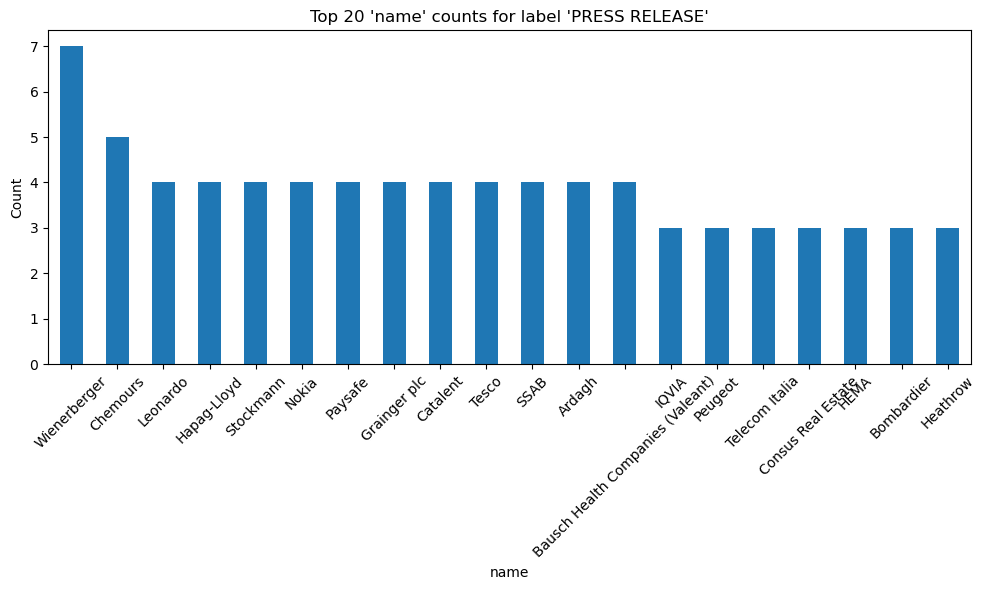

In [26]:
# EDA - Check a look at distribution of given var across each of the 3 labels
def plot_label_name_counts(dataframe, name_column, label_column, top_n=20):
    
    unique_labels = dataframe[label_column].unique()

    for label in unique_labels:
        label_df = dataframe[dataframe[label_column] == label]
        top_names = label_df[name_column].value_counts().head(top_n)

        plt.figure(figsize=(10, 6))
        top_names.plot(kind='bar', rot=45)
        plt.title(f"Top {top_n} '{name_column}' counts for label '{label}'")
        plt.xlabel(name_column)
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

# EDA - Check a look at distribution of names across each of the 3 labels
plot_label_name_counts(titles_df, name_column='name', label_column='label', top_n=20)

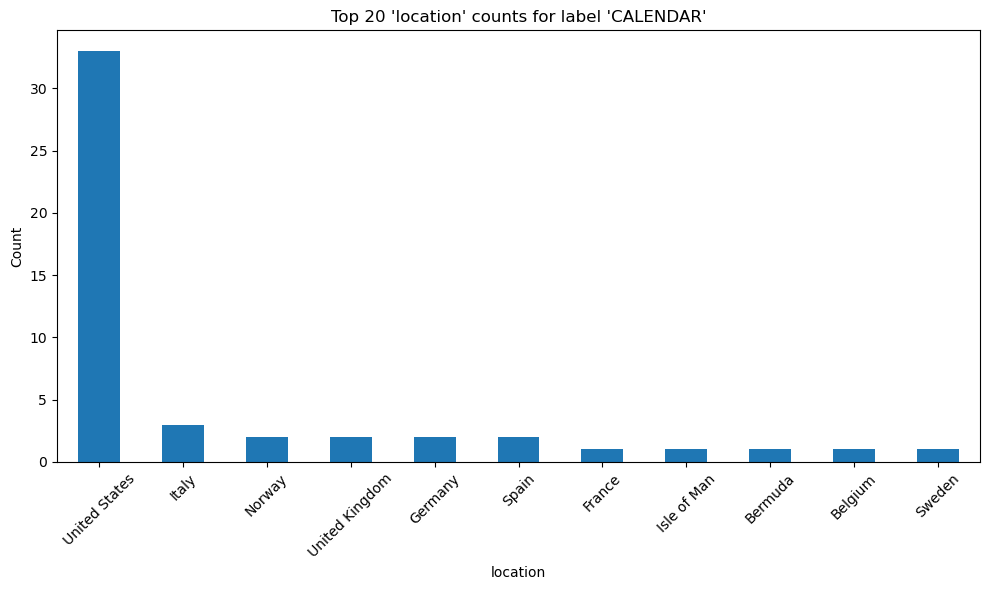

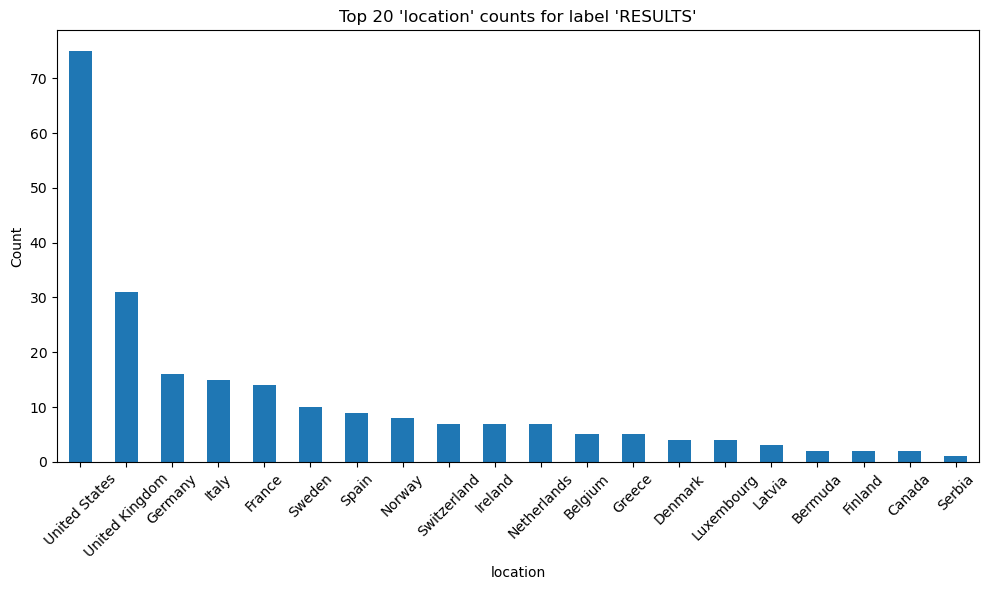

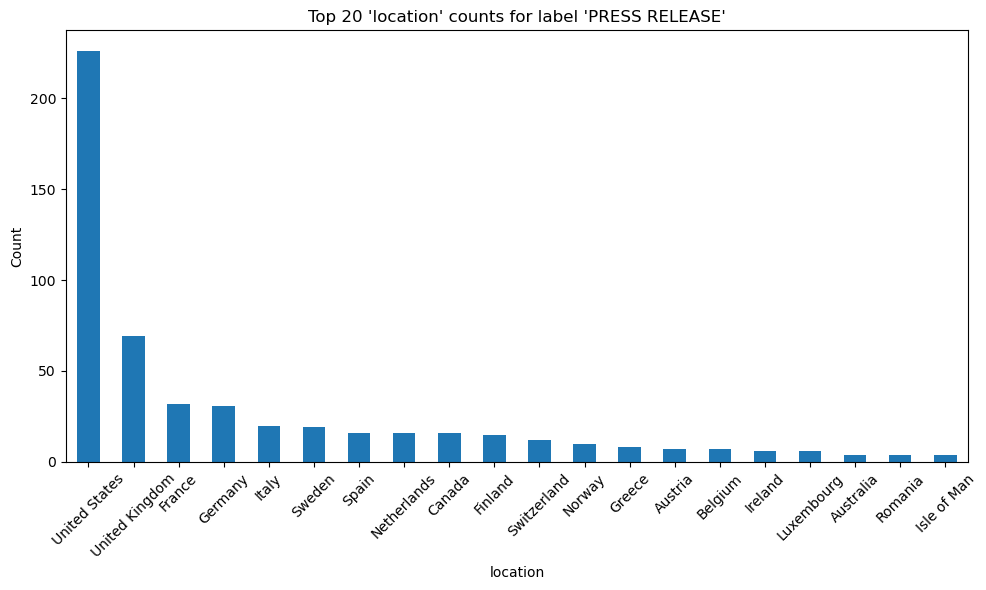

In [27]:
# EDA - Check a look at distribution of location across each of the 3 labels
plot_label_name_counts(titles_df, name_column='location', label_column='label', top_n=20)

# Feature Engineering

In this section, I focused on transforming date-related and text features, from the dataset. The published_at field was decomposed into components such as year, month, day, day_of_week, hour, and quarter. I also built multi-lingual embedding features from the title, company name and description fields. This is as one of my models experimented with using flattened embeddings. This required some text preprocessing, which you can see in the preprocess_text function.

In [28]:
# Feature Engineering - Separate date into components
def extract_datetime_features_and_reorder(input_df):
    df=input_df.copy()
    df['year'] = pd.to_datetime(df['published_at']).dt.year
    df['month'] = pd.to_datetime(df['published_at']).dt.month
    df['day'] = pd.to_datetime(df['published_at']).dt.day
    df['day_of_week'] = pd.to_datetime(df['published_at']).dt.dayofweek
    df['hour'] = pd.to_datetime(df['published_at']).dt.hour
    df['quarter'] = pd.to_datetime(df['published_at']).dt.quarter
    df.drop(columns=['published_at'], inplace=True)
    
    return df

titles_df_preprocessed = extract_datetime_features_and_reorder(titles_df)

In [29]:
# Feature Engineering - Preprocess title by lemmatizing, removing stopwords, special characters and numbers,
# and converting to lower case
def preprocess_text(text):
    
    # Initialize lemmatizer and stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize words
    words = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(words)

In [30]:
# Preprocess title, name of company and description of company
titles_df_preprocessed['title_cleaned'] = titles_df['title'].apply(preprocess_text)
titles_df_preprocessed['name_cleaned'] = titles_df['name'].apply(preprocess_text)
titles_df_preprocessed['description_cleaned'] = titles_df['description'].apply(preprocess_text)

In [32]:
# Further Feature Engineering - Embed title, name, description (for our second model solution)
def add_embeddings(df, columns):
    
    # Load the model
    model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

    # For each column, generate embeddings and add them to the DataFrame
    for column in columns:
        new_column = f"{column}_embedded"
        df[new_column] = df[column].apply(lambda text: model.encode(text, convert_to_numpy=True))
    
    return df

cols_to_embed=['name_cleaned','description_cleaned', 'title_cleaned']
titles_df_preprocessed = add_embeddings(titles_df_preprocessed, cols_to_embed)

In [33]:
# Further Feature Engineering - Flatten embeddings to be used in model 
def expand_embeddings(df, col_name):
    embeddings = np.stack(df[col_name].to_numpy())
    columns = [f"{col_name}_{i}" for i in range(embeddings.shape[1])]
    embedding_df = pd.DataFrame(embeddings, columns=columns, index=df.index)  # Preserve the DataFrame index
    return pd.concat([df, embedding_df], axis=1)

titles_df_preprocessed = expand_embeddings(titles_df_preprocessed, 'name_cleaned_embedded')
titles_df_preprocessed= expand_embeddings(titles_df_preprocessed, 'description_cleaned_embedded')
titles_df_preprocessed = expand_embeddings(titles_df_preprocessed, 'title_cleaned_embedded')

In [34]:
# Further Feature Engineering - Encode Categorical column location
label_encoder = LabelEncoder()
titles_df_preprocessed['location_encoded'] = label_encoder.fit_transform(titles_df_preprocessed['location'])


# Model Training - Logistic Regression

In this section, I trained three logistic regression models for the classification task. The first model served as a baseline, using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization on the title field as the only feature. The second model enhanced the feature set by incorporating additional fields such as description, company name, and date, alongside the TF-IDF vectors for the title. These steps aimed to provide richer context for the classification task.

The final model returned to using just the title field but addressed the class imbalance by applying SMOTE (Synthetic Minority Oversampling Technique) to oversample the minority class (CALENDAR). This final approach yielded the best overall performance across the three classes, with improvements in precision, recall, and F1-score. As a result, this model was selected for analysis and stakeholder reporting.

## Further Feature Engineering

In [42]:
# Feature engineering - TFIDF 

#Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Limit to 1000 features for simplicity

# Transform the cleaned titles into TF-IDF features
tfidf_features = tfidf_vectorizer.fit_transform(titles_df_preprocessed['title_cleaned'])

# Display the shape of the resulting feature matrix
tfidf_features.shape

(849, 1000)

## Model Training - Logistic Regression (Baseline)

In [43]:
# Split data into training and testing sets 80/20 split.
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, titles_df_preprocessed['label'], test_size=0.2, random_state=42)

In [44]:
# Train a Logistic Regression model
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [45]:
# Evaluate on the training set
y_train_pred = log_reg.predict(X_train)

# Generate classification report for the training set
train_classification_report = classification_report(y_train, y_train_pred, target_names=['CALENDAR', 'PRESS RELEASE', 'RESULTS'])

# Print the classification report for the training set
print("Training Set Classification Report:")
print(train_classification_report)

Training Set Classification Report:
               precision    recall  f1-score   support

     CALENDAR       0.71      1.00      0.83        42
PRESS RELEASE       0.98      0.92      0.95       459
      RESULTS       0.87      0.94      0.91       178

     accuracy                           0.93       679
    macro avg       0.86      0.95      0.90       679
 weighted avg       0.94      0.93      0.93       679



In [46]:
# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the models precision, recall, f1-score and distributions, using inbuilt classification report
classification_report_output = classification_report(y_test, y_pred, target_names=['CALENDAR', 'PRESS RELEASE', 'RESULTS'])

In [47]:
print(classification_report_output)

               precision    recall  f1-score   support

     CALENDAR       0.60      0.86      0.71         7
PRESS RELEASE       0.86      0.94      0.90       103
      RESULTS       0.91      0.72      0.80        60

     accuracy                           0.86       170
    macro avg       0.79      0.84      0.80       170
 weighted avg       0.87      0.86      0.86       170



## Model Training - Logistic Regression w/ more features + embeddings

In [48]:
# Model building - Prepare features (X) and labels (y)
normal_columns = ['location_encoded', 'day', 'quarter']
feature_columns = [col for col in titles_df_preprocessed.columns 
                   if col.startswith('description_cleaned_embedded_') or
                   col.startswith('title_cleaned_embedded_') or col in normal_columns]

X = titles_df_preprocessed[feature_columns]
y = titles_df_preprocessed['label']

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert target to numeric labels

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [49]:
# Train Logistic Regression Classifier
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate precision, recall, and F1 score
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)

               precision    recall  f1-score   support

     CALENDAR       0.24      0.50      0.32        10
PRESS RELEASE       0.92      0.87      0.89       112
      RESULTS       0.75      0.69      0.72        48

     accuracy                           0.79       170
    macro avg       0.64      0.68      0.64       170
 weighted avg       0.83      0.79      0.81       170



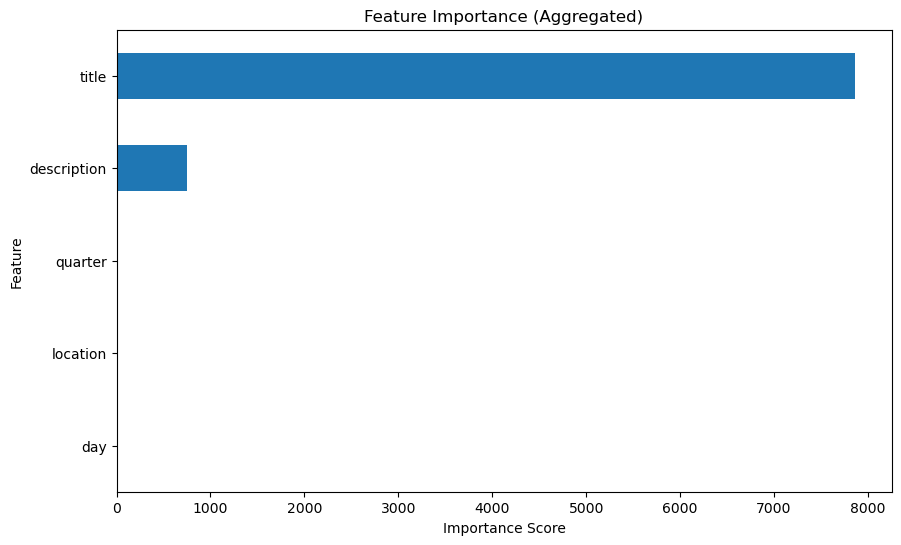

In [50]:

# Feature importance calculation using ANOVA F-test scores
# Logistic Regression does not directly provide feature importance, so we use F-statistics
f_scores, p_values = f_classif(X_train, y_train)

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    "feature": X.columns,
    "importance": f_scores
})

# Aggregate importances by high-level feature
def aggregate_feature_name(name):
    if "_" in name:
        return name.split("_")[0]  # Extract base feature name (e.g., text1_embedded)
    return name

feature_importances["base_feature"] = feature_importances["feature"].apply(aggregate_feature_name)
aggregated_importance = feature_importances.groupby("base_feature")["importance"].sum().sort_values(ascending=False)

# Plot the aggregated feature importance
plt.figure(figsize=(10, 6))
aggregated_importance.plot(kind="barh")
plt.title("Feature Importance (Aggregated)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()


## Model Training Logistic Regression - Over Sampling Minority Class

In [53]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_features, 
    titles_df_preprocessed['label'],
    test_size=0.2, 
    random_state=42
)

# Apply SMOTE to the training data to apply augmentation to the minority class
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train a Logistic Regression model
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_reg.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

In [54]:
# Evaluate the model
classification_report_output = classification_report(
    y_test, 
    y_pred, 
    target_names=['CALENDAR', 'PRESS RELEASE', 'RESULTS']
)
print(classification_report_output)

               precision    recall  f1-score   support

     CALENDAR       0.75      0.86      0.80         7
PRESS RELEASE       0.88      0.95      0.91       103
      RESULTS       0.90      0.75      0.82        60

     accuracy                           0.88       170
    macro avg       0.84      0.85      0.84       170
 weighted avg       0.88      0.88      0.87       170



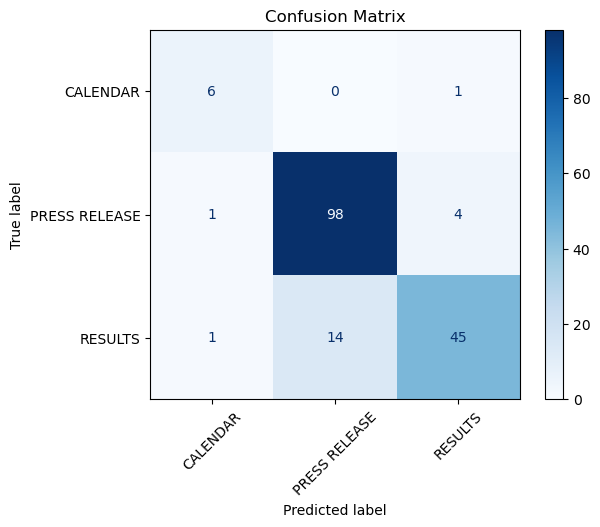

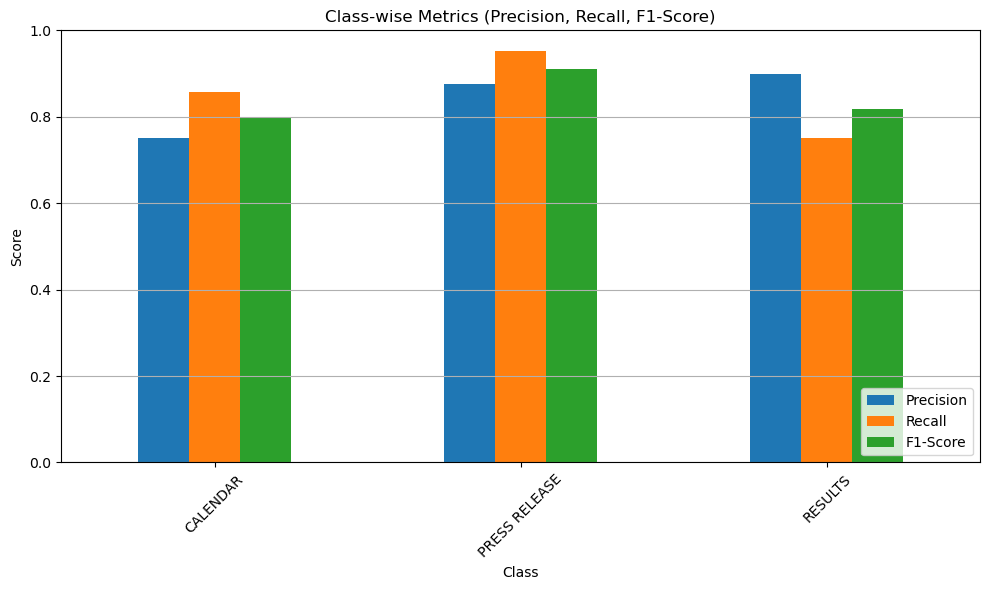

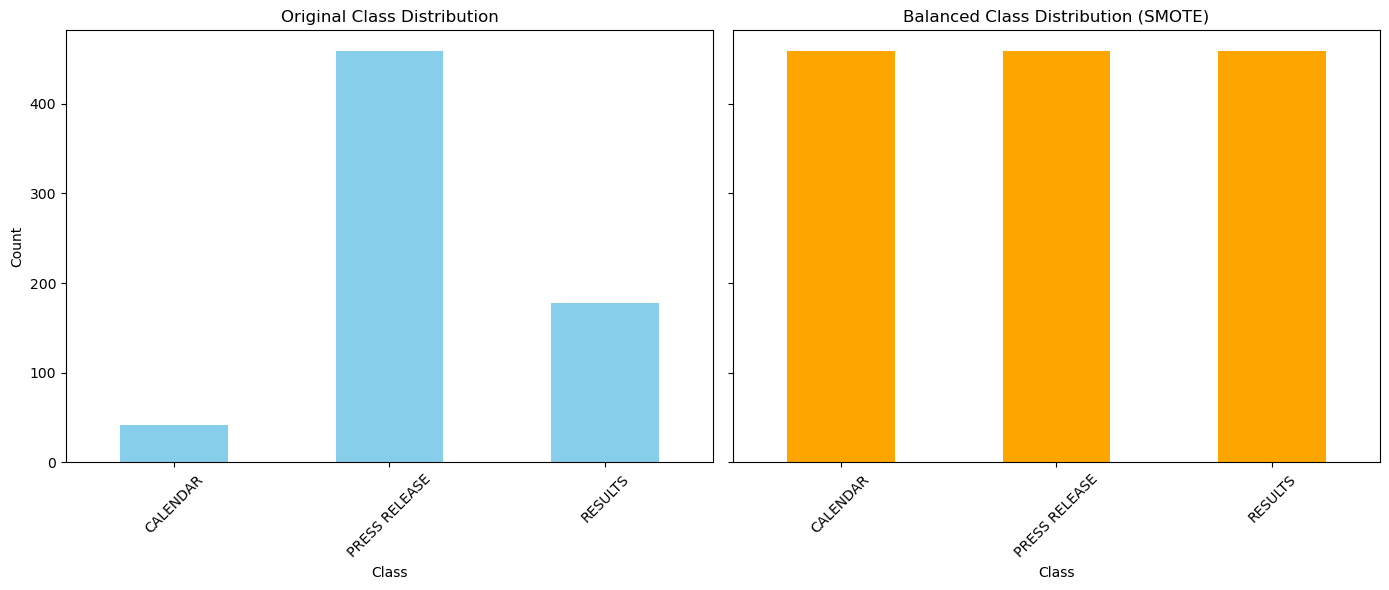

In [52]:
# Visualization 1: Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, class_names):
    cm = confusion_matrix(y_test, y_pred, labels=class_names)  # Use string labels directly
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()
    
# Visualization 2: Bar Chart of Precision, Recall, and F1-Score
def plot_classification_report(y_test, y_pred, class_names):
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    metrics = {
        "Precision": precision_score(y_test, y_pred, average=None, zero_division=0),
        "Recall": recall_score(y_test, y_pred, average=None, zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, average=None, zero_division=0),
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)
    metrics_df.plot(kind='bar', figsize=(10, 6))
    plt.title("Class-wise Metrics (Precision, Recall, F1-Score)")
    plt.xlabel("Class")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')
    plt.ylim(0, 1.0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Visualization 3: Class Distribution Before and After SMOTE
def plot_class_distribution(original_labels, balanced_labels, class_names):
    original_counts = pd.Series(original_labels).value_counts().sort_index()
    balanced_counts = pd.Series(balanced_labels).value_counts().sort_index()

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    original_counts.plot(kind='bar', ax=axes[0], title='Original Class Distribution', color='skyblue')
    axes[0].set_xlabel("Class")
    axes[0].set_ylabel("Count")
    axes[0].set_xticklabels(class_names, rotation=45)

    balanced_counts.plot(kind='bar', ax=axes[1], title='Balanced Class Distribution (SMOTE)', color='orange')
    axes[1].set_xlabel("Class")
    axes[1].set_ylabel("Count")
    axes[1].set_xticklabels(class_names, rotation=45)

    plt.tight_layout()
    plt.show()

# Generate Confusion Matrix Visualization
class_names = ['CALENDAR', 'PRESS RELEASE', 'RESULTS']  

# String labels
plot_confusion_matrix(y_test, y_pred, class_names)

# Classification Report Bar Chart
plot_classification_report(y_test, y_pred, class_names)

# Class Distribution Comparison
# Assuming y_train is the original labels and y_train_balanced is the post-SMOTE labels
plot_class_distribution(y_train, y_train_balanced, class_names)


# Model Performance Metrics for Stakeholders

<u>**Task Summary**</u>

We developed a Logistic Regression model to classify data into three categories: CALENDAR, RESULTS, and PRESS RELEASE. This classification task is particularly challenging due to the imbalanced distribution of classes in the dataset: CALENDAR had only 49 examples, compared to 238 for RESULTS and 562 for PRESS RELEASE.

To address this imbalance and ensure the model learned effectively from all classes, we applied SMOTE (Synthetic Minority Oversampling Technique). SMOTE artificially generates new examples for underrepresented classes (like CALENDAR) by interpolating between existing data points. This preprocessing step balanced the training data and helped mitigate bias toward the majority class.

<u>**Key Results:**</u>

Overall Model Accuracy: **88%**

This indicates that the model correctly classifies 88% of the test samples into their respective categories. However, while accuracy is a helpful general metric, it does not account for the class imbalance, so we also examined class-specific performance metrics.

**Class-Specific Performance:**

* CALENDAR: Precision = 75%, Recall = 86%, F1-Score = 80%

* PRESS RELEASE: Precision = 88%, Recall = 95%, F1-Score = 91%

* RESULTS: Precision = 90%, Recall = 75%, F1-Score = 82%

The model demonstrates strong overall performance, reliably classifying the majority of data into the correct categories. It performs exceptionally well for the PRESS RELEASE category, with very accurate and consistent predictions. For RESULTS, while the model is precise, it occasionally misses some true instances, suggesting potential improvements in recall. The CALENDAR category poses the greatest challenge, with some overlap in predictions due to its smaller representation in the dataset. Moving forward, we can enhance performance by collecting more diverse data for underrepresented categories and exploring advanced modeling techniques to better capture subtle differences between classes.


<u>**Next Steps:**</u>


1. Improve recall for the RESULTS category by exploring alternative models or feature engineering.
2. Ensure reliable predictions for the CALENDAR category by gathering more articles within of this label to use in training our model.
    
<u>**Model Performance Visualisations:**</u>


**Explanation:** This matrix shows the number of correct and incorrect predictions for each category (CALENDAR, PRESS RELEASE, RESULTS). It shows how well the model correctly predicts each category. The diagonal cells represent correct predictions, while off-diagonal cells show mistakes. 

**Takeway:** The model demonstrates strong performance for PRESS RELEASE, showing high accuracy and consistency in predictions. For CALENDAR, while the model successfully identifies most true instances, it struggles with precision, meaning that some predictions for this category are incorrectly classified. 

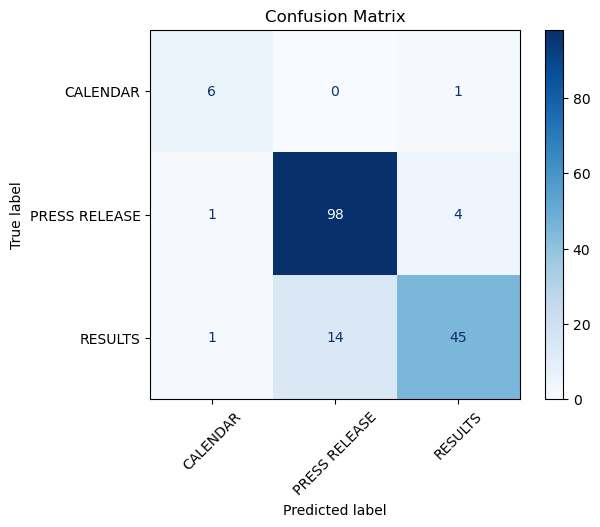

**Explanation:** A bar chart showing **precision** (how often predictions are correct when the model predicts a category), **recall** (how well the model finds all items of a category), and **F1-score** (A balance between precision and recall), for CALENDAR, PRESS RELEASE, and RESULTS. 

**Takeaway:** The model is highly accurate for PRESS RELEASE. CALENDAR has lower precision, meaning some predictions for CALENDAR are incorrect.

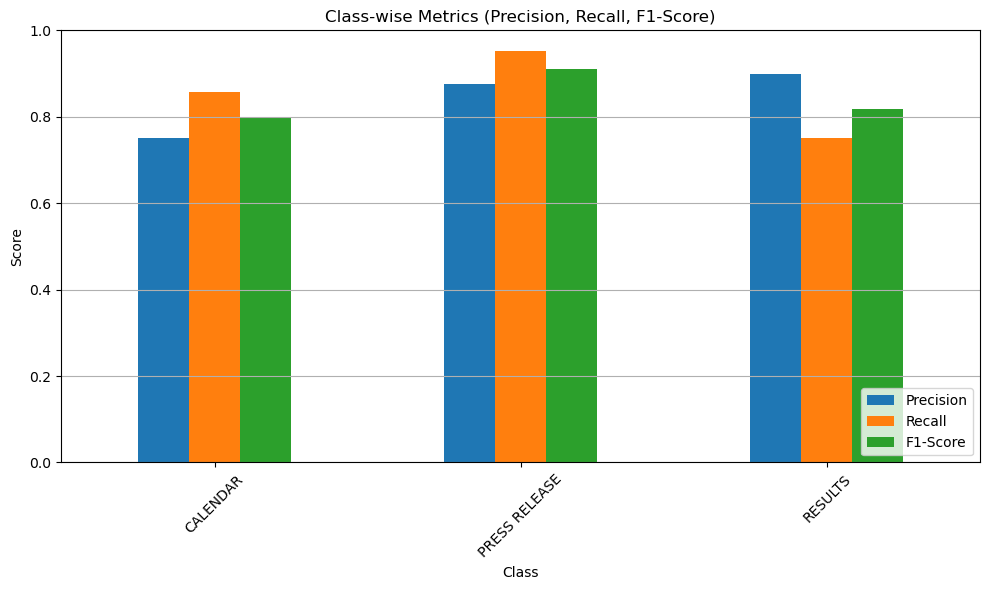

**Explanation:** The first chart shows that CALENDAR had far fewer examples than other categories, making it harder for the model to learn. The second chart shows how we balanced the data to give the model more examples for CALENDAR.

**Takeaway:** After balancing, all categories have an equal number of examples, helping the model learn more effectively.

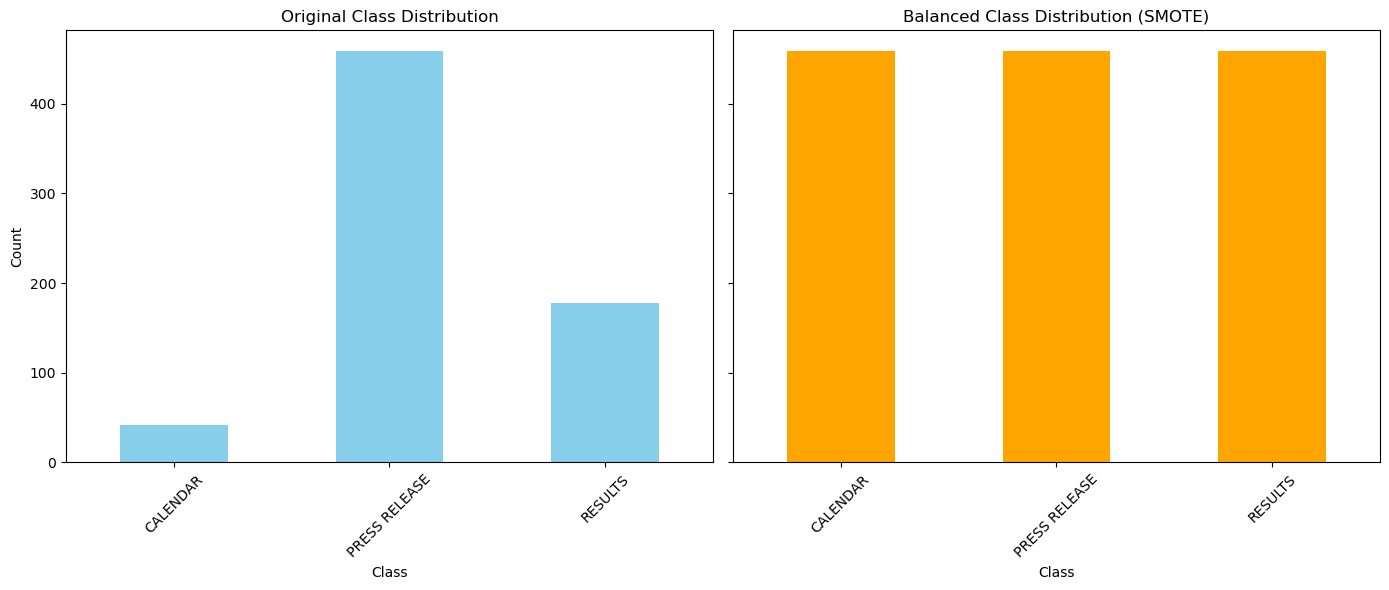
